# Introduction

In this notebook we check whether the [repeating FRB](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1603.00581) events are distributed according to [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution), using the [Anderson Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test).

# Mathematical Formulation
See [separate document](https://docs.google.com/document/d/1d2kO6ja6GW_dJSTF5zvYF2qNBHAMDyhg9DfHrLEqTxs/edit?usp=sharing).

# Application for the repeating FRB

Load libraries and set up environment

In [48]:
import numpy
import scipy.special
import pylab

Load data

In [1]:
times_txt = numpy.loadtxt('code/times.txt', skiprows=1)
observations_txt = numpy.loadtxt('code/observations.txt', skiprows=1)

Total cumulative observation time

In [2]:
total_cumulative_observation_time = numpy.sum(observations_txt.T[-2])

Calculate correction for disperion measure

In [3]:
import astropy.time
dm_correction = [astropy.time.TimeDelta(4.148808e3*559/line[7]**2, format='sec') for line in observations_txt]

Geographical correction for light travel time

In [4]:
import astropy.coordinates
frb_loc = astropy.coordinates.SkyCoord('05:31:58','+33:08:04',
                                       unit=(astropy.units.hourangle,astropy.units.deg),equinox='J2000')
arecibo_loc = astropy.coordinates.EarthLocation.from_geodetic(lon=-66.7528,lat=18.3464) #index 0
effelsberg_loc = astropy.coordinates.EarthLocation.from_geodetic(lon='6:52:58',lat='50:31:29') #index 1
gbt_loc = astropy.coordinates.EarthLocation.from_geodetic(lon='-79.8398',lat='38.4322') #index 2
vla_loc = astropy.coordinates.EarthLocation.from_geodetic(lon='-107.6184',lat='34.0784') #index 3
lovell_loc = astropy.coordinates.EarthLocation.from_geodetic(lon='-2.3085',lat='53.2367') #index 4
locs = [arecibo_loc,effelsberg_loc,gbt_loc,vla_loc,lovell_loc] #locations of all involved observatories
light_travel_times = [astropy.time.Time('%04i-%02i-%02iT%02i:%02i:%02i'%(line[0],
                                                    line[1],
                                                    line[2],
                                                    line[3],
                                                    line[4],
                                                    line[5]),
                  format='isot',
                   scale='utc',
                  location=locs[int(line[6])]).light_travel_time(frb_loc)
             for line in observations_txt]

Calculate observation start time in mjd and apply the corrections above

In [5]:
start_times_raw = [astropy.time.Time('%04i-%02i-%02iT%02i:%02i:%02i'%(line[0],
                                                                line[1],
                                                                line[2],
                                                                line[3],
                                                                line[4],
                                                                line[5]),
                              format='isot',
                               scale='utc',
                              location=locs[int(line[6])])
             for line in observations_txt]

start_mjd = [(tstart.tdb-dmcorr+tlt).mjd 
             for tstart,dmcorr,tlt in 
             zip(start_times_raw, dm_correction, light_travel_times)]

Calculate the cumulative times for the FRB events in seconds (this is the time measured from the begininng of the first observation if all observation windows are concatenated)

In [15]:
t_frb_cumulative = numpy.zeros_like(times_txt.T[0])
for n, line in enumerate(times_txt):
    idx = int(line[-1])
    idx_in_observations = numpy.where(observations_txt.T[-1]>0)[0][idx]
    t_frb_cumulative[n] = numpy.sum(observations_txt.T[-2][:idx_in_observations+1]) + (line[0]-start_mjd[idx_in_observations])*3600

In [23]:
numpy.where(observations_txt[-1]>0)[0]

array([0, 1, 2, 4, 5, 7, 8])

Detection times within observational window

In [28]:
local_burst_times = []
for start_h, duration_s in zip(start_mjd,observations_txt.T[-2]):
    temp = []
    start_s = 3600*start_h
    end_s = start_s+duration_s
    for line in times_txt:
        if end_s>line[0]*3600 and line[0]*3600>start_s:
            temp.append(line[0]*3600-start_s)
    local_burst_times.append(temp)
local_burst_times = numpy.array(local_burst_times)
local_burst_times

array([list([5.348158895969391]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([6.861075937747955, 30.703098356723785]), list([]),
       list([15.89056459069252, 39.59510299563408, 193.85107097029686, 194.7965677678585, 197.21232616901398, 204.97192460298538, 212.02439299225807, 214.40908339619637]),
       list([18.64650371670723, 19.592000514268875, 22.007758915424347, 29.767357349395752, 36.81982573866844, 39.204516142606735]),
       list([]), list([]), list([265.04672142863274]), list([]),
       list([106.66864031553268]), list([]), list([]), list([]), list([]),
       list([]),
       list([4383.02034330368, 4400.288373559713, 4418.674936681986, 4436.019026607275]),
       list([772.9384613037109, 790.2064915597439, 808.5930546820164, 825.9371446073055]),
       list([641.9325594305992, 659.2005896866322, 677.5871528089046, 694.9312427341938]),
       list([581.5131857693195, 598.7812160253525, 617.167779

Calculate $\chi^2_{\min}$

In [116]:
def anderson_darling_weibull_single(k,r,window,times):
    
    N = len(times)
    n_list = numpy.array(range(len(times)))+1
    rT = window*r
    aux_1 = (k+1)*rT**(-1-k)/(scipy.special.gamma(1.0+1.0/k))**k
    aux_2 = 0.5*(rT**2)/(2-k)
    if N==0:
        return aux_1*aux_2
    aux_3 = (rT/(1-k))*numpy.sum(1-(times/window)**(1-k))
    aux_4 = (0.5/k)*numpy.sum((2*n_list-1)*((window/times)**k-1))
    return aux_1*(aux_2-aux_3+aux_4)
anderson_darling_weibull_single(0.3,1,observations_txt.T[-2][0],local_burst_times[0])

7.28108781415081

In [117]:
anderson_darling_weibull_single(0.8,1e-3,observations_txt.T[-2][0], local_burst_times[0])

331.66729090583766

In [118]:
def calc_chi_squared(k,r):
    return numpy.sum([window*anderson_darling_weibull_single(k,r,window,times)
                      for window, times
                      in zip(observations_txt.T[-2], local_burst_times)])/numpy.sum(observations_txt.T[-2])
calc_chi_squared(0.3,1e-4)

12.46956382519269

In [119]:
[anderson_darling_weibull_single(0.8,1e-3,window,times)
                      for window, times
                      in zip(observations_txt.T[-2], local_burst_times)]

[331.66729090583766,
 0.4821832290507025,
 0.8279678147244652,
 0.765890361263957,
 0.6745757623892931,
 0.7362246810327445,
 0.6789689755625943,
 0.6789689755625943,
 0.6789689755625943,
 0.6789689755625943,
 0.5719448739972864,
 91.5465132976962,
 0.6789689755625943,
 198.58509286742964,
 537.7994535972637,
 0.5334584969199665,
 1.073373248451889,
 0.38600232177362354,
 0.9630642481050593,
 1.0912127842477293,
 0.8454747402289927,
 0.8454747402289927,
 0.8454747402289927,
 0.8454747402289927,
 0.9942567041088671,
 0.651029551099462,
 1.8717335613001531,
 4.341902001444068,
 5.14785411611499,
 29.56815434209509,
 0.750465888531915,
 0.8454747402289927,
 0.81798559948354,
 0.9494251137460604,
 0.8761414315334985,
 0.9461054890143626,
 0.8281515897828322,
 0.8763856862220134,
 0.9862599261918664,
 0.8763368570660257,
 1.0923482999446537,
 0.8763368570660257,
 0.8763368570660257,
 0.5815010804573486,
 16.989529066110713,
 1.0075146994114208,
 0.8532768700684235,
 0.8763856862220134,
 0.8

In [120]:
calc_chi_squared(0.8,1e-3)

4.568542666135226

<IPython.core.display.Javascript object>


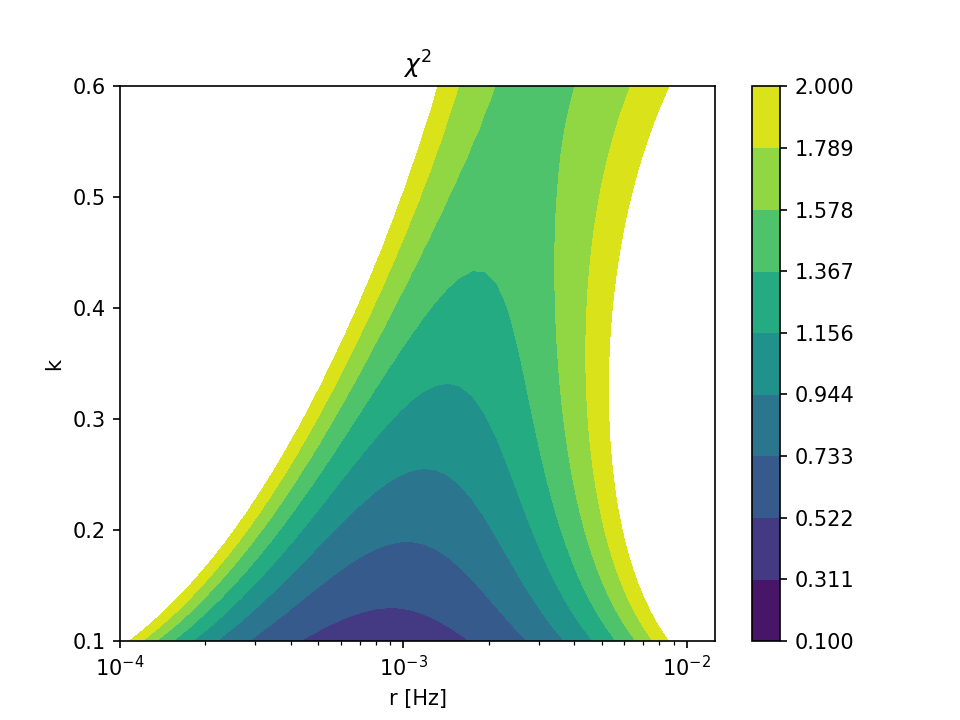

In [139]:
r_list = numpy.logspace(-4,-1.9,50)
k_list = numpy.linspace(0.1,0.6,40)
chi2_list = [[calc_chi_squared(k,r) 
    for r in r_list]
    for k in k_list]
%matplotlib notebook
pylab.contourf(r_list, k_list, chi2_list, numpy.linspace(0.1,2,10))
pylab.colorbar()
pylab.xscale('log')
pylab.xlabel('r [Hz]')
pylab.ylabel('k')
pylab.title(r'$\chi^2$')
pass